In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from typing import List, Dict

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [10, 5]
plt.rc('figure', autolayout=True)

In [3]:
from src.variables import tickers, period, observation_window, monte_carlo_simulation, SEED

graphics=True

In [6]:
random.seed(SEED)
np.random.seed(SEED)

In [7]:
ticker = tickers[0]

In [8]:
data: pd.DataFrame = pd.read_csv(f'./results/data/{ticker}.csv', index_col='Date', parse_dates=True)
label: str = f"{ticker} period {data.index.min().strftime('%Y-%m-%d')} - {data.index.max().strftime('%Y-%m-%d')}"

In [11]:
adj_close: pd.DataFrame = pd.read_csv(f'./results/prediction/{ticker}/{label}/Adj Close.csv', index_col='Date', parse_dates=True)
prediction: pd.DataFrame = pd.read_csv(f'./results/prediction/Expected Return.csv', index_col='Ticker')

In [13]:
prediction

,Expected Returns,Volatility,Drift,Test Volatility,Test Drift
Ticker,,,,,
ABEV3.SA,0.017776,0.0158,0.000294,0.016211,0.000322


In [ ]:
## Validation

drift: float = prediction.loc[ticker, 'Test Drift']
volatilidade: float = prediction.loc[ticker, 'Test Volatility']

forecast: List[float] = []
precos_simulados: Dict[int, List[float]] = dict()

for n in range(monte_carlo_simulation):

    precos_simulados[n] = [data['Adj Close'][-observation_window["stepsFoward"]]]

    for i in range(observation_window["stepsFoward"]):

        preco_simulado: float = precos_simulados[n][-1] * (1 + random.gauss(drift, volatilidade))
        precos_simulados[n].append(preco_simulado)

    forecast.append(precos_simulados[n][-1])

if graphics:
    plt.title(f'Simulação Monte Carlo Para os Preço em {observation_window["stepsFoward"]} dias (Validação)')
    plt.hist(forecast, density = True, bins=20)
    plt.xlabel('Preço')
    plt.ylabel('Frequência')

    if not os.path.exists(f'./results/graphics/{ticker}/{label}/Simulation Monte Carlo'):
        os.makedirs(f'./results/graphics/{ticker}/{label}/Simulation Monte Carlo')

    plt.savefig(f'./results/graphics/{ticker}/{label}/Simulation Monte Carlo/[VALIDATION] Return.png')
    plt.close()

    plt.title(f'Simulação Monte Carlo Para os Preços em {observation_window["stepsFoward"]} dias (Validação)')

    soma: List[float] = [0 for _ in range(observation_window["stepsFoward"])]

    for _, value in precos_simulados.items():
        valueSeries: pd.Series = pd.Series(
            value[:observation_window["stepsFoward"]],
            index=adj_close[:observation_window["stepsFoward"]].index
        )   

        plt.plot(valueSeries, linestyle='--', linewidth=1)

        soma: List[float] = [x + y for x, y in zip(soma, value)]

    forecast_mean: List[float] = [x / monte_carlo_simulation for x in soma]
    pd_forecast_mean: pd.Series = pd.Series(forecast_mean, index=adj_close.index[: observation_window["stepsFoward"]])  

    plt.plot(pd_forecast_mean, label = "Média das Previsões", color = 'black', linestyle='-.', linewidth=3)
    plt.plot(data['Adj Close'][-2 * observation_window["stepsFoward"]: - observation_window["stepsFoward"]], color = 'black', label = 'StepsBack', linestyle='-', linewidth=3)
    plt.plot(data['Adj Close'][-observation_window["stepsFoward"]:], color = 'red', label = 'Fact', linestyle='-', linewidth=3)
    plt.plot(adj_close.index[-observation_window["stepsFoward"]], forecast_mean[-1], 'ro')
    plt.text(adj_close.index[-observation_window["stepsFoward"]], forecast_mean[-1], f'{forecast_mean[-1]:.2f}', fontsize=12, verticalalignment='bottom', horizontalalignment='left')
    plt.xticks(rotation=45)
    plt.legend(loc = 'best') 
    plt.savefig(f'./results/graphics/{ticker}/{label}/Simulation Monte Carlo/[VALIDATION] Close Price.png')

    plt.close()

In [14]:
## Validation

In [15]:
drift: float = prediction.loc[ticker, 'Test Drift']
volatilidade: float = prediction.loc[ticker, 'Test Volatility']

In [38]:
1 + random.gauss(drift, volatilidade)

1.0263933363349913

In [39]:
forecast: List[float] = []
precos_simulados: Dict[int, List[float]] = dict()

for n in range(monte_carlo_simulation):

    precos_simulados[n] = [data['Adj Close'][-observation_window["stepsFoward"]]]

    for i in range(observation_window["stepsFoward"]):

        preco_simulado: float = precos_simulados[n][-1] * (1 + random.gauss(drift, volatilidade))
        precos_simulados[n].append(preco_simulado)

    forecast.append(precos_simulados[n][-1])

[]

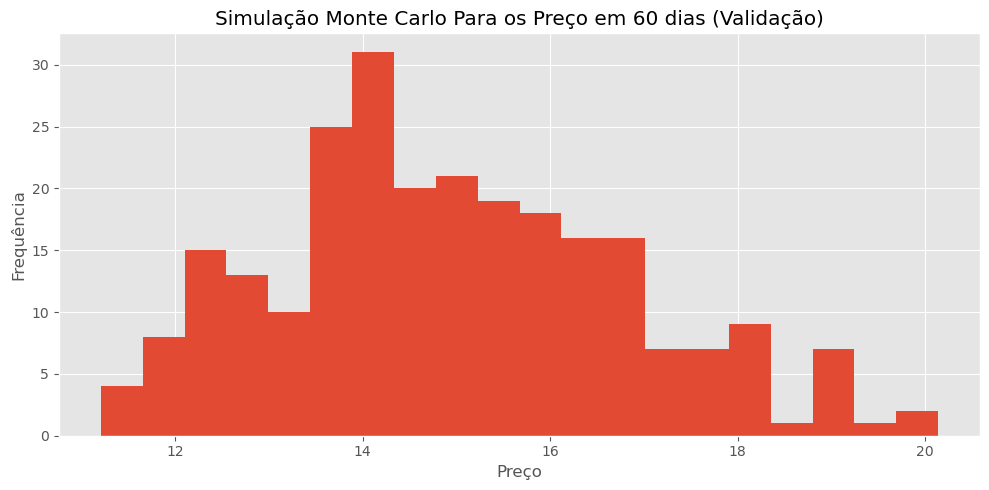

In [42]:
plt.title(f'Simulação Monte Carlo Para os Preço em {observation_window["stepsFoward"]} dias (Validação)')
plt.hist(forecast, bins=20)
plt.xlabel('Preço')
plt.ylabel('Frequência')

if not os.path.exists(f'./results/graphics/{ticker}/{label}/Simulation Monte Carlo'):
    os.makedirs(f'./results/graphics/{ticker}/{label}/Simulation Monte Carlo')

# plt.savefig(f'./results/graphics/{ticker}/{label}/Simulation Monte Carlo/[VALIDATION] Return.png')
plt.plot()

# plt.close()


In [50]:
pd_forecast_mean

Date
2022-10-06    14.579578
2022-10-07    14.606379
2022-10-10    14.595268
2022-10-11    14.612522
2022-10-13    14.618050
2022-10-14    14.601113
2022-10-17    14.631881
2022-10-18    14.635193
2022-10-19    14.629114
2022-10-20    14.639214
2022-10-21    14.651475
2022-10-24    14.663031
2022-10-25    14.678719
2022-10-26    14.686446
2022-10-27    14.711792
2022-10-28    14.726037
2022-10-31    14.728769
2022-11-01    14.744473
2022-11-03    14.748650
2022-11-04    14.766950
2022-11-07    14.777940
2022-11-08    14.770287
2022-11-09    14.784281
2022-11-10    14.786233
2022-11-11    14.808857
2022-11-14    14.838152
2022-11-16    14.837354
2022-11-17    14.827897
2022-11-18    14.829133
2022-11-21    14.838341
2022-11-22    14.827710
2022-11-23    14.858246
2022-11-24    14.869457
2022-11-25    14.864603
2022-11-28    14.854529
2022-11-29    14.879465
2022-11-30    14.883388
2022-12-01    14.877261
2022-12-02    14.879209
2022-12-05    14.887217
2022-12-06    14.898459
2022-12-07 

[]

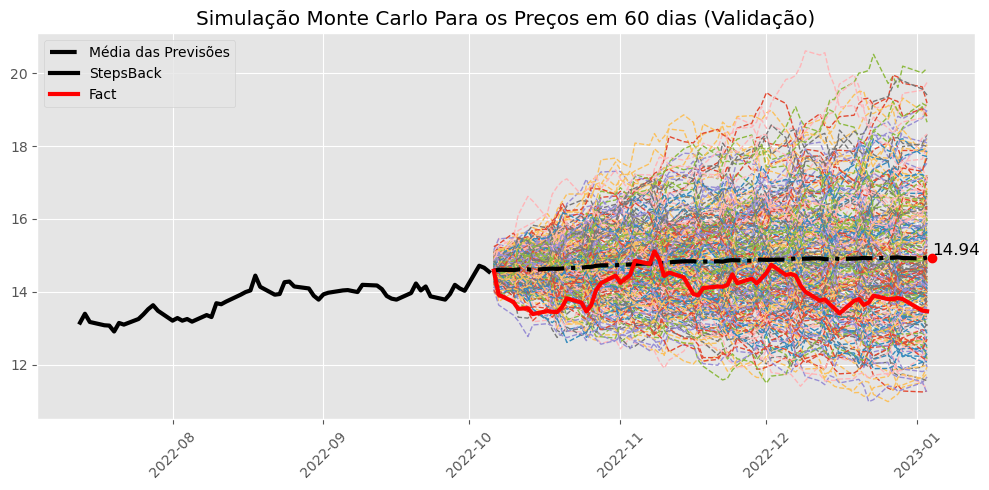

In [48]:
plt.title(f'Simulação Monte Carlo Para os Preços em {observation_window["stepsFoward"]} dias (Validação)')

soma: List[float] = [0 for _ in range(observation_window["stepsFoward"])]

for _, value in precos_simulados.items():
    valueSeries: pd.Series = pd.Series(
        value[- observation_window['stepsFoward']:],
        index=adj_close[:observation_window["stepsFoward"]].index
    )   

    plt.plot(valueSeries, linestyle='--', linewidth=1)

    soma = [x + y for x, y in zip(soma, value)]

forecast_mean: List[float] = [x / monte_carlo_simulation for x in soma]
pd_forecast_mean: pd.Series = pd.Series(forecast_mean, index=adj_close.index[: observation_window["stepsFoward"]])  

plt.plot(pd_forecast_mean, label = "Média das Previsões", color = 'black', linestyle='-.', linewidth=3)
plt.plot(data['Adj Close'][-2 * observation_window["stepsFoward"]: - observation_window["stepsFoward"]], color = 'black', label = 'StepsBack', linestyle='-', linewidth=3)
plt.plot(data['Adj Close'][-observation_window["stepsFoward"]:], color = 'red', label = 'Fact', linestyle='-', linewidth=3)
plt.plot(adj_close.index[-observation_window["stepsFoward"]], forecast_mean[-1], 'ro')
plt.text(adj_close.index[-observation_window["stepsFoward"]], forecast_mean[-1], f'{forecast_mean[-1]:.2f}', fontsize=12, verticalalignment='bottom', horizontalalignment='left')
plt.xticks(rotation=45)
plt.legend(loc = 'best') 
# plt.savefig(f'./results/graphics/{ticker}/{label}/Simulation Monte Carlo/[VALIDATION] Close Price.png')
plt.plot()
# plt.close()

In [44]:
soma

[3644.894599914551,
 3651.594869412372,
 3648.8169404126656,
 3653.130461667986,
 3654.512427282337,
 3650.278253355206,
 3657.9703297345063,
 3658.798229353168,
 3657.278428003052,
 3659.803588534981,
 3662.8687574565884,
 3665.7578561953437,
 3669.679694841134,
 3671.611544992397,
 3677.94806793312,
 3681.509165431747,
 3682.192304082198,
 3686.118358992121,
 3687.162392414335,
 3691.737539938318,
 3694.4850590649394,
 3692.571812707008,
 3696.070323364383,
 3696.558337827157,
 3702.2141930174957,
 3709.5380389707684,
 3709.3385520096695,
 3706.974176978313,
 3707.283216149893,
 3709.5853007683727,
 3706.9275154290535,
 3714.5614322918923,
 3717.364254826102,
 3716.150848752765,
 3713.6322532029503,
 3719.8663116025323,
 3720.847041300278,
 3719.3152808810073,
 3719.8021623506443,
 3721.804287974489,
 3724.614802064711,
 3729.3763957351357,
 3727.0473546814305,
 3727.3583582165083,
 3730.010974274505,
 3724.0134062353095,
 3723.439808329389,
 3730.0666158454765,
 3725.124243045367,
 

In [ ]:
## Forecast

In [ ]:
drift: float = prediction.loc[ticker, 'Test Drift']
volatilidade: float = prediction.loc[ticker, 'Test Volatility']

forecast: List[float] = []
precos_simulados: Dict[int, List[float]] = dict()

for n in range(monte_carlo_simulation):

    precos_simulados[n] = [data['Adj Close'][-1]]

    for i in range(observation_window["stepsFoward"]):

        preco_simulado: float = precos_simulados[n][-1] * (1 + random.gauss(drift, volatilidade))
        precos_simulados[n].append(preco_simulado)

    forecast.append(precos_simulados[n][-1])

plt.hist(forecast, density = True)
plt.title(f'Simulação Monte Carlo Para os Preço em {observation_window["stepsFoward"]} dias')
plt.xlabel('Preço')
plt.ylabel('Frequência')            
plt.savefig(f'./results/graphics/{ticker}/{label}/Simulation Monte Carlo/Return.png')
plt.close()


plt.title(f'Simulação Monte Carlo Para os Preços em {observation_window["stepsFoward"]} dias')

soma: List[float] = [0 for _ in range(observation_window["stepsFoward"])]

for _, value in precos_simulados.items():
    valueSeries: pd.Series = pd.Series(
        value[- observation_window["stepsFoward"]:],
        index=adj_close.index[- observation_window["stepsFoward"]:])    
    plt.plot(valueSeries, linestyle='--', linewidth=1)

    soma: List[float] = [x + y for x, y in zip(soma, value)]

forecast_mean: List[float] = [x / monte_carlo_simulation for x in soma]
pd_forecast_mean: pd.Series = pd.Series(forecast_mean, index=adj_close.index[- observation_window["stepsFoward"]:])    

plt.plot(pd_forecast_mean, label = "Média de Previsões", color = 'black', linestyle='-.', linewidth=3)
plt.plot(data['Adj Close'][-60:], color = 'black', label = 'StepsBack', linestyle='-', linewidth=3)
plt.legend(loc = 'best')
plt.plot(adj_close.index[-1], forecast_mean[-1], 'ro')
plt.text(adj_close.index[-1], forecast_mean[-1], f'{forecast_mean[-1]:.2f}', fontsize=12, verticalalignment='bottom', horizontalalignment='left')
plt.xticks(rotation=45)
plt.savefig(f'./results/graphics/{ticker}/{label}/Simulation Monte Carlo/Close Price.png')
plt.close()

